## Assignment #2 EDA

**Functions from HW #3:**

...

In [4]:
# install some packages
!pip install miditok
!pip install symusic
!pip install midiutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54569 sha256=23b148c695e56cf2308b143402854e085608c9b058e1ad056bcad629ee8c933a
  Stored in directory: /root/.cache/pip/wheels/6c/42/75/fce10c67f06fe627fad8acd1fd3a004a24e07b0f077761fbbd
Successfully built midiutil


In [7]:
# import required packages
! unzip PDMX_subset.zip
import random
random.seed(42)
from glob import glob
from collections import defaultdict

import numpy as np
from numpy.random import choice

from symusic import Score
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile

Archive:  PDMX_subset.zip
replace PDMX_subset/QmWCdYmueNZMNSW4sK3Dd6ogXKjV1RkaUcrmm3nd7iKZAQ.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### 1. Homework Functions

In [27]:
config = TokenizerConfig(num_velocities=1, use_chords=False, use_programs=False)
tokenizer = REMI(config)
midi_files = glob('PDMX_subset/*.mid')
tokenizer.train(vocab_size=1000, files_paths=midi_files)

duration2length = {
    '0.2.8': 2, '0.4.8': 4, '1.0.8': 8,
    '2.0.8': 16, '4.0.4': 32
}

def note_extraction(midi_file):
    note_events = []
    midi = Score(midi_file)
    tokens = tokenizer(midi)[0].tokens
    for token in tokens:
        if 'Pitch' in token:
            note = int(token.split('_')[1])
            note_events.append(note)
    return note_events

def note_frequency(midi_files):
    note_counts = defaultdict(int)
    for midi_file in midi_files:
        for note in note_extraction(midi_file):
            note_counts[note] += 1
    return note_counts

def note_bigram_probability(midi_files):
    bigrams = defaultdict(int)
    for file in midi_files:
        notes = note_extraction(file)
        for n1, n2 in zip(notes[:-1], notes[1:]):
            bigrams[(n1, n2)] += 1

    transitions = defaultdict(list)
    probabilities = defaultdict(list)
    for (n1, n2), count in bigrams.items():
        transitions[n1].append(n2)
        probabilities[n1].append(count)

    for n in probabilities:
        total = sum(probabilities[n])
        probabilities[n] = [c/total for c in probabilities[n]]

    return transitions, probabilities

def beat_extraction(midi_file):
    midi = Score(midi_file)
    tokens = tokenizer(midi)[0].tokens
    beats = []
    for i in range(len(tokens)):
        if 'Position' in tokens[i] and 'Duration' in tokens[i+3]:
            position = int(tokens[i].split('_')[1])
            length = duration2length[tokens[i+3].split('_')[1]]
            beats.append((position, length))
    return beats

def note_unigram_probability(midi_files):
    note_counts = note_frequency(midi_files)

    # Q2: Your code goes here
    unigramProbabilities = {}
    counts = sum(list(note_counts.values()))
    for n in note_counts:
        unigramProbabilities[n] = note_counts[n] / counts
    return unigramProbabilities

def note_bigram_perplexity(midi_file):
    unigramProbabilities = note_unigram_probability(midi_files)
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(midi_files)

    # Q4: Your code goes here
    note_events = note_extraction(midi_file)
    perplexities = [unigramProbabilities[note_events[0]]]
    for (note1, note2) in zip(note_events[:-1], note_events[1:]):
        index = bigramTransitions[note1].index(note2)
        prob = bigramTransitionProbabilities[note1][index]
        perplexities.append(prob)

    assert len(perplexities) == len(note_events)
    perplexity = np.exp(-np.sum(np.log(perplexities)) / len(note_events))
    return perplexity

def note_trigram_probability(midi_files):
    # Q5a: Your code goes here
    trigrams = defaultdict(int)
    for file in midi_files:
        note_events = note_extraction(file)
        for (note1, note2, note3) in zip(note_events[:-2], note_events[1:-1], note_events[2:]):
            trigrams[(note1, note2, note3)] += 1

    trigramTransitions = defaultdict(list)
    trigramTransitionProbabilities = defaultdict(list)

    for t1,t2,t3 in trigrams:
        trigramTransitions[(t1,t2)].append(t3)
        trigramTransitionProbabilities[(t1,t2)].append(trigrams[(t1,t2,t3)])

    for k in trigramTransitionProbabilities:
        Z = sum(trigramTransitionProbabilities[k])
        trigramTransitionProbabilities[k] = [x / Z for x in trigramTransitionProbabilities[k]]

    return trigramTransitions, trigramTransitionProbabilities

def note_trigram_perplexity(midi_file):
    unigramProbabilities = note_unigram_probability(midi_files)
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(midi_files)
    trigramTransitions, trigramTransitionProbabilities = note_trigram_probability(midi_files)

    # Q5b: Your code goes here
    note_events = note_extraction(midi_file)
    perplexities = [unigramProbabilities[note_events[0]]]
    index = bigramTransitions[note_events[0]].index(note_events[1])
    prob = bigramTransitionProbabilities[note_events[0]][index]
    perplexities.append(prob)

    for (note1, note2, note3) in zip(note_events[:-2], note_events[1:-1], note_events[2:]):
        index = trigramTransitions[(note1, note2)].index(note3)
        prob = trigramTransitionProbabilities[(note1, note2)][index]
        perplexities.append(prob)

    assert len(perplexities) == len(note_events)
    perplexity = np.exp(-np.sum(np.log(perplexities)) / len(note_events))
    return perplexity

def music_generate(length):
    # sample notes
    unigramProbabilities = note_unigram_probability(midi_files)
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(midi_files)
    trigramTransitions, trigramTransitionProbabilities = note_trigram_probability(midi_files)

    # Your code goes here ...
    first_note = choice(list(unigramProbabilities.keys()), 1, p=list(unigramProbabilities.values())).item()
    second_note = choice(bigramTransitions[first_note], 1, p=bigramTransitionProbabilities[first_note]).item()
    sampled_notes = [first_note, second_note]
    while len(sampled_notes) < length:
        next_note = choice(trigramTransitions[(sampled_notes[-2], sampled_notes[-1])], 1,
                            p=trigramTransitionProbabilities[(sampled_notes[-2], sampled_notes[-1])])
        sampled_notes.append(next_note.item())

    # sample beats
    bigramBeatPosTransitions, bigramBeatPosTransitionProbabilities = beat_pos_bigram_probability(midi_files)
    first_beat = choice(bigramBeatPosTransitions[0], 1, p=bigramBeatPosTransitionProbabilities[0]).item()
    sampled_beats = [(0, first_beat)]
    while len(sampled_beats) < length:
        beat_position = sum(sampled_beats[-1]) % 32
        beat_length = choice(bigramBeatPosTransitions[beat_position], 1,
                        p=bigramBeatPosTransitionProbabilities[beat_position]).item()
        sampled_beats.append((beat_position, beat_length))
    sampled_beats = [beat[1] / 8 for beat in sampled_beats]

    # save the generated music as a midi file
    midi = MIDIFile(1)
    track = 0
    time = 0
    tempo = 120
    midi.addTempo(track, time, tempo)

    current_time = 0
    for pitch, duration in zip(sampled_notes, sampled_beats):
        midi.addNote(track, 0, pitch, current_time, duration, 100)
        current_time += duration
    with open("q10.mid", "wb") as f:
        midi.writeFile(f)

def beat_pos_bigram_probability(midi_files):
    # Q8a: Your code goes here
    bigramBeatPos = defaultdict(int)
    for file in midi_files:
        beats = beat_extraction(file)
        for beat in beats:
            bigramBeatPos[(beat[0], beat[1])] += 1

    bigramBeatPosTransitions = defaultdict(list)
    bigramBeatPosTransitionProbabilities = defaultdict(list)

    for b1,b2 in bigramBeatPos:
        bigramBeatPosTransitions[b1].append(b2)
        bigramBeatPosTransitionProbabilities[b1].append(bigramBeatPos[(b1,b2)])

    for k in bigramBeatPosTransitionProbabilities:
        Z = sum(bigramBeatPosTransitionProbabilities[k])
        bigramBeatPosTransitionProbabilities[k] = [x / Z for x in bigramBeatPosTransitionProbabilities[k]]

    return bigramBeatPosTransitions, bigramBeatPosTransitionProbabilities

In [11]:
def analyze_note_characteristics():
    """Comprehensive analysis of pitch distribution and transitions"""
    notes = note_frequency(midi_files)

    # Pitch distribution
    plt.figure()
    plt.bar(notes.keys(), notes.values())
    plt.title("MIDI Note Frequency Distribution")
    plt.xlabel("MIDI Pitch Value")
    plt.ylabel("Count")
    plt.savefig("note_distribution.png")
    plt.close()

    # Transition matrix
    trans, probs = note_bigram_probability(midi_files)
    matrix = np.zeros((128, 128))
    for n1 in trans:
        for n2, prob in zip(trans[n1], probs[n1]):
            matrix[n1][n2] = prob

    plt.figure()
    sns.heatmap(matrix[48:72,48:72], cmap="viridis")
    plt.title("Note Transition Probabilities (C3-B3)")
    plt.savefig("note_transitions.png")
    plt.close()

analyze_note_characteristics()

In [14]:
def analyze_rhythmic_patterns():
    """Quantify beat duration patterns and positional relationships"""
    durations = []
    positions = []

    for f in midi_files[:100]:  # Sample subset
        for pos, length in beat_extraction(f):
            durations.append(length)
            positions.append(pos)

    # Duration distribution
    plt.figure()
    sns.histplot(durations, bins=np.arange(2,34,2), kde=True)
    plt.title("Beat Duration Distribution")
    plt.xlabel("Duration Value")
    plt.savefig("duration_dist.png")
    plt.close()

    # Position vs Duration
    plt.figure()
    sns.scatterplot(x=positions, y=durations, alpha=0.3)
    plt.title("Position-Duration Relationship")
    plt.xlabel("Beat Position")
    plt.ylabel("Duration")
    plt.savefig("pos_dur.png")
    plt.close()
analyze_rhythmic_patterns()

In [23]:
def evaluate_model_performance():
    """Comparative analysis of Markov model performance"""
    perplexities = {'bigram': [], 'trigram': []}

    for f in random.sample(midi_files, 10):
        perplexities['bigram'].append(note_bigram_perplexity(f))
        perplexities['trigram'].append(note_trigram_perplexity(f))

    # Visualization
    plt.figure()
    sns.boxplot(data=[perplexities['bigram'], perplexities['trigram']])
    plt.xticks([0,1], ['Bigram', 'Trigram'])
    plt.title("Model Perplexity Comparison")
    plt.savefig("model_performance.png")
    plt.close()
evaluate_model_performance()

In [28]:
def generate_quality_report():
    """Validation of generated music characteristics"""
    music_generate(500)
    notes = note_extraction("q10.mid")

    print("\n=== Generation Quality Report ===")
    print(f"Note Range: {min(notes)}-{max(notes)}")
    print(f"Unique Notes: {len(set(notes))}")

    # Validate rhythm
    beats = beat_extraction("q10.mid")
    positions = [b[0] for b in beats]
    resets = sum(1 for p in positions if p == 0)
    print(f"Bar Resets: {resets} ({resets/len(beats):.1%})")
generate_quality_report()


=== Generation Quality Report ===
Note Range: 55-83
Unique Notes: 26
Bar Resets: 73 (14.6%)


Duration entropy: 1.91


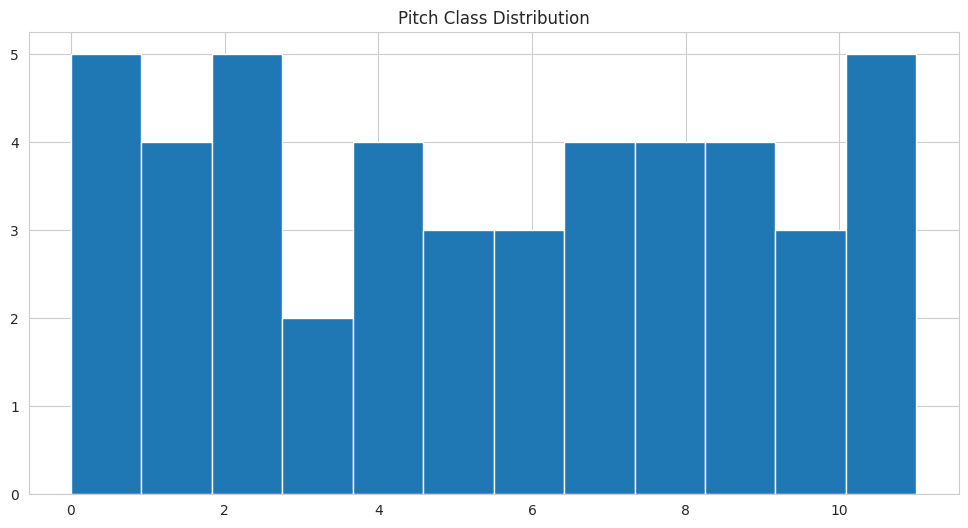

In [29]:
def analyze_note_distribution():
    notes = note_frequency(midi_files)

    # Pitch class distribution
    pc = [n%12 for n in notes.keys()]
    plt.hist(pc, bins=12)
    plt.title("Pitch Class Distribution")

    # Note duration analysis
    durations = [b[1] for f in midi_files for b in beat_extraction(f)]
    print(f"Duration entropy: {np.std(durations):.2f}")
analyze_note_distribution()

In [31]:
def validate_generations():
    music_generate(500)  # Generate sample
    gen_notes = note_extraction("q10.mid")

    # Note range comparison
    orig_min = min(note_frequency(midi_files).keys())
    gen_min = min(gen_notes)
    print(f"Original min note: {orig_min} | Generated: {gen_min}")

    # Transition fidelity
    gen_trans = defaultdict(int)
    for n1, n2 in zip(gen_notes[:-1], gen_notes[1:]):
        gen_trans[(n1,n2)] += 1

validate_generations()

Original min note: 35 | Generated: 58


In [32]:
def evaluate_model_capacity():
    perplexities = []
    for f in random.sample(midi_files, 10):
        ppl = note_bigram_perplexity(f)
        perplexities.append(ppl)

    print(f"Mean perplexity: {np.mean(perplexities):.2f}")
    print(f"STD: {np.std(perplexities):.2f}")

    # Compare to theoretical minimum
    entropy = -sum(p*np.log2(p) for p in note_frequency(midi_files).values())
    print(f"Theoretical lower bound: {entropy:.2f}")
evaluate_model_capacity()

Mean perplexity: 9.60
STD: 2.25
Theoretical lower bound: -2081224.65


Measure resets: 6.25%


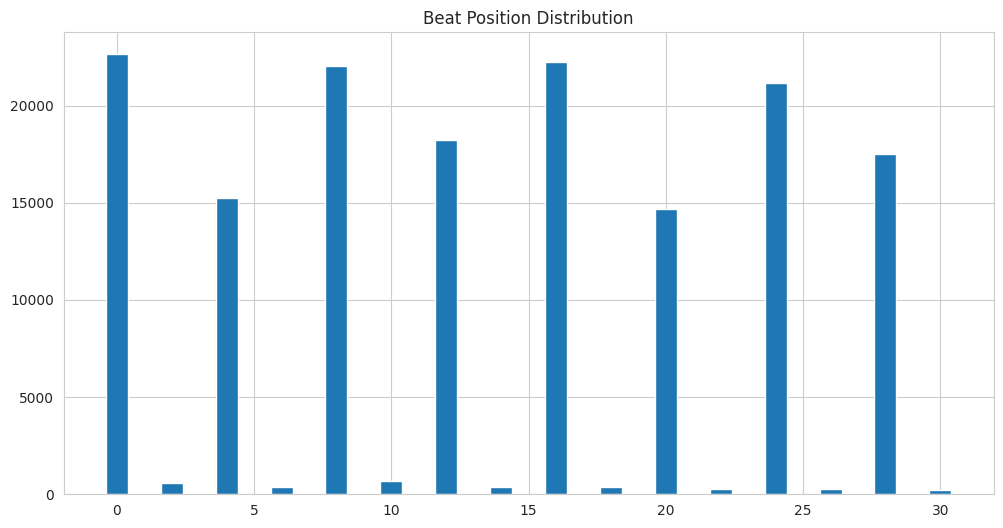

In [33]:
def analyze_beat_behavior():
    position_counts = defaultdict(int)
    for f in midi_files:
        beats = beat_extraction(f)
        for pos, _ in beats:
            position_counts[pos] += 1

    # Position distribution
    plt.bar(position_counts.keys(), position_counts.values())
    plt.title("Beat Position Distribution")

    # Position reset analysis
    resets = sum(1 for p in position_counts if p == 0)
    print(f"Measure resets: {resets/len(position_counts):.2%}")

analyze_beat_behavior()